# Generalized Mutual Information

We compute the generalized mutual information on the noisy-label MNIST problem

# Reference problem

We define a very easy classification problem
in order to calibrate the scale of MMD and Wasserstein divergences,
since those divergences are not expressed in nats.

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args([])
use_cuda = not args.no_cuda and torch.cuda.is_available()


def corruption_to_mi_wrong(alpha):
    return np.log(k) + np.log(1-(1-1./k)*alpha)


def corruption_to_mi(alpha, k=10.):
    p_y_true = (1-alpha) + alpha / k
    p_y_false = alpha / k + 1e-8 # prevemnt 0 alpha error
    entropy = np.log(k)
    conditional_entropy = -(p_y_true * np.log(p_y_true) + (k-1) * p_y_false * np.log(p_y_false))
    return entropy - conditional_entropy
    
#alpha = np.linspace(0, 1, 100)
#k = 10
#mi = corruption_to_mi(alpha)
#plt.plot(alpha, mi)
#plt.xlabel('Ratio of corrupted labels')
#plt.ylabel('Mutual information (nats)')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = self.fc1(x.view(len(x), -1))
        return F.log_softmax(x, dim=1)
    
    
def do_epoch(args, mode, model, device, loader, optimizer=None, info=''):
    if mode=='train':
        model.train()
    else:
        model.eval()
        
    losses = []
    accuracies = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = F.nll_loss(output, target)

        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        if mode == 'train':
            #print 'training'
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if batch_idx % args.log_interval == 0:
            print('{} Batch {}/{} Accuracy {:.3f}\tLoss: {:.3f}'.format(
                info, batch_idx, len(loader), np.mean(accuracies), np.mean(losses)))
    return losses, accuracies



# Reference problem
class ReferenceDataset(torch.utils.data.Dataset):

    def __init__(self):
        X = torch.zeros(10, 784)
        Y = torch.arange(10)
        for i in xrange(10):
            X[i, 78*i:78*(i+1)] = 1
        X = X.view(len(X), 1, 28, 28)        

        # Repeat X and Y 6000 times
        X = np.repeat(X, 6000, 0)
        Y = np.repeat(Y, 6000, 0)
        
        self.X = X
        self.Y = Y
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    
class CorruptedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, corruption, classes=None):
        self.dataset = dataset
        self.corruption = corruption
        self.corrupted = (np.random.uniform(size=len(dataset)) < corruption)
        print ('Corrupting dataset')
        if classes is not None:
            self.labels = np.repeat(np.arange(classes), len(dataset)/classes)
        else:
            self.labels = np.asarray([y for x,y in self.dataset])
        np.random.shuffle(self.labels)
        self.labels = torch.LongTensor(self.labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.corrupted[idx]:
            y = self.labels[idx]
        return x, y
    
    

#torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)


corruptions = np.linspace(0, 1, 5)


def make_infinite(iterator):
    while True:
        for x in iterator:
            yield x
            

def compute_divergence(Net, corruptions, reference=False):

    # Train Parametric
    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption = {}'.format(corruption))

        model = Net().to(device)
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)
            test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(), corruption)
            test_corrupted = CorruptedDataset(ReferenceDataset(), corruption)
           
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=args.batch_size, shuffle=True, **kwargs)
        test_corrupted_loader = torch.utils.data.DataLoader(test_corrupted, batch_size=args.test_batch_size, shuffle=True, **kwargs)

        for epoch in range(1, args.epochs + 1):
            train_losses, train_accuracies = do_epoch(args, 'train', model, device, train_corrupted_loader, 
                                                      optimizer, info='Train Epoch {}'.format(epoch))

            print ('Corruption: {}, MI: {:.2} bits / {:.2} nats'.format(corruption, corruption_to_mi(corruption), corruption_to_mi(corruption)/np.log(2)))

            test_losses, test_accuracies = do_epoch(args, 'test', model, device, test_corrupted_loader, info='Test {}'.format(epoch))
            print ('CORRUPTED {}'.format(np.mean(test_losses)))


        all_train_losses.append(np.mean(train_losses))
        all_test_losses.append(np.mean(test_losses))

    return all_train_losses, all_test_losses

# Neural Divergence

In [321]:
all_train_losses, all_test_losses = compute_divergence(Net, corruptions)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'mnist_cnn.pt')

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.047	Loss: 2.309
Train Epoch 1 Batch 100/938 Accuracy 0.350	Loss: 2.265
Train Epoch 1 Batch 200/938 Accuracy 0.499	Loss: 2.010
Train Epoch 1 Batch 300/938 Accuracy 0.611	Loss: 1.539
Train Epoch 1 Batch 400/938 Accuracy 0.677	Loss: 1.259
Train Epoch 1 Batch 500/938 Accuracy 0.722	Loss: 1.074
Train Epoch 1 Batch 600/938 Accuracy 0.753	Loss: 0.945


KeyboardInterrupt: 

In [39]:
all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'mnist_logistic.pt')

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.078	Loss: 2.558
Train Epoch 1 Batch 100/938 Accuracy 0.791	Loss: 0.768
Train Epoch 1 Batch 200/938 Accuracy 0.835	Loss: 0.604
Train Epoch 1 Batch 300/938 Accuracy 0.852	Loss: 0.535
Train Epoch 1 Batch 400/938 Accuracy 0.861	Loss: 0.497
Train Epoch 1 Batch 500/938 Accuracy 0.867	Loss: 0.476
Train Epoch 1 Batch 600/938 Accuracy 0.873	Loss: 0.453
Train Epoch 1 Batch 700/938 Accuracy 0.878	Loss: 0.437
Train Epoch 1 Batch 800/938 Accuracy 0.880	Loss: 0.425
Train Epoch 1 Batch 900/938 Accuracy 0.883	Loss: 0.414
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/10 Accuracy 0.902	Loss: 0.297
CORRUPTED 0.30762244761
Corruption = 0.25
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.078	Loss: 2.491
Train Epoch 1 Batch 100/938 Accuracy 0.597	Loss: 1.533
Train Epoch 1 Batch 200/938 Accuracy 0.631	Loss: 1.447
Train Epoch 1 Batch 300/938 Accuracy 0.646	Loss: 1.417
Train Epoch 1

In [94]:
all_train_losses, all_test_losses = compute_divergence(Net, corruptions)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'reference_cnn.pt')

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.156	Loss: 2.306
Train Epoch 1 Batch 100/938 Accuracy 0.610	Loss: 1.434
Train Epoch 1 Batch 200/938 Accuracy 0.743	Loss: 0.931
Train Epoch 1 Batch 300/938 Accuracy 0.800	Loss: 0.720
Train Epoch 1 Batch 400/938 Accuracy 0.832	Loss: 0.602
Train Epoch 1 Batch 500/938 Accuracy 0.853	Loss: 0.520
Train Epoch 1 Batch 600/938 Accuracy 0.869	Loss: 0.463
Train Epoch 1 Batch 700/938 Accuracy 0.882	Loss: 0.417
Train Epoch 1 Batch 800/938 Accuracy 0.890	Loss: 0.384
Train Epoch 1 Batch 900/938 Accuracy 0.899	Loss: 0.355
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/10 Accuracy 0.969	Loss: 0.114
CORRUPTED 0.105619766563
Corruption = 0.25
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.047	Loss: 2.334
Train Epoch 1 Batch 100/938 Accuracy 0.430	Loss: 1.974
Train Epoch 1 Batch 200/938 Accuracy 0.548	Loss: 1.684
Train Epoch 1 Batch 300/938 Accuracy 0.598	Loss: 1.567
Train Epoch 

In [95]:
all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions, reference=True)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'reference_logistic.pt')

Corruption = 0.0
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.094	Loss: 2.304
Train Epoch 1 Batch 100/938 Accuracy 0.972	Loss: 0.425
Train Epoch 1 Batch 200/938 Accuracy 0.986	Loss: 0.237
Train Epoch 1 Batch 300/938 Accuracy 0.991	Loss: 0.167
Train Epoch 1 Batch 400/938 Accuracy 0.993	Loss: 0.130
Train Epoch 1 Batch 500/938 Accuracy 0.994	Loss: 0.107
Train Epoch 1 Batch 600/938 Accuracy 0.995	Loss: 0.091
Train Epoch 1 Batch 700/938 Accuracy 0.996	Loss: 0.079
Train Epoch 1 Batch 800/938 Accuracy 0.997	Loss: 0.070
Train Epoch 1 Batch 900/938 Accuracy 0.997	Loss: 0.063
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/60 Accuracy 1.000	Loss: 0.006
CORRUPTED 0.0063584327853
Corruption = 0.25
Corrupting dataset
Corrupting dataset
Train Epoch 1 Batch 0/938 Accuracy 0.125	Loss: 2.242
Train Epoch 1 Batch 100/938 Accuracy 0.749	Loss: 1.210
Train Epoch 1 Batch 200/938 Accuracy 0.761	Loss: 1.124
Train Epoch 1 Batch 300/938 Accuracy 0.767	Loss: 1.089
Train Epoch

# Intra and Inter-class Variances

In [322]:
# Compute MNIST intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in train_dataset:
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(-1, 28*28)
    
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))


Variance class 0: 49.92
Variance class 1: 22.48
Variance class 2: 50.76
Variance class 3: 44.94
Variance class 4: 40.87
Variance class 5: 47.58
Variance class 6: 43.09
Variance class 7: 37.47
Variance class 8: 45.60
Variance class 9: 38.57
Inter-class variance: 52.73


Variance class 0: 0.00
Variance class 1: 0.00
Variance class 2: 0.00
Variance class 3: 0.00
Variance class 4: 0.00
Variance class 5: 0.00
Variance class 6: 0.00
Variance class 7: 0.00
Variance class 8: 0.00
Variance class 9: 0.00
Inter-class variance: 70.20


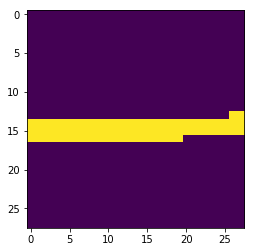

In [323]:
# Compute Reference intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in ReferenceDataset():
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(-1, 28*28)
    
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))

plt.imshow(X[5].mean(0).view(28,28))

# MMD

In [19]:
# MMD
class MMDKernel(object):
    def dot(self, x1, x2):
        raise Exception('Implement')

    def h(self, X1, Y1, X2, Y2):
        k_X1_X2 = self.dot(X1, X2)
        k_Y1_Y2 = self.dot(Y1, Y2)
        k_X1_Y2 = self.dot(X1, Y2)
        k_X2_Y1 = self.dot(X2, Y1)
        stat =  k_X1_X2 + k_Y1_Y2 - k_X1_Y2 - k_X2_Y1
        return stat
    
    def split(self, X):
        return X[0::2], X[1::2]
    
        
class GaussianKernel(MMDKernel):
    def __init__(self, sigma=1.):
        self.sigma = sigma
        
    def dot(self, x1, x2):
        x1 = x1.view(len(x1), -1)  # flatten
        x2 = x2.view(len(x2), -1)  # flatten
        
        delta = x1-x2
        dot = (delta*delta).mean(1)
        return np.exp(-dot / self.sigma**2)


class ZeroOneKernel(MMDKernel):
    def dot(self, y1, y2):
        # Return 1 or less (shouldn't be zero)
        return np.exp(-(y1 != y2).float())

    
    
class JointKernel(MMDKernel):
    def __init__(self, kx, ky):
        self.kx = kx
        self.ky = ky
        
    def dot(self, (x1, y1), (x2, y2)):
        dotx = self.kx.dot(x1, x2)
        doty = self.ky.dot(y1, y2)
        return dotx * doty
    
    def split(self, (X_image, X_label)):
        X1 = (X_image[0::2], X_label[0::2])
        X2 = (X_image[1::2], X_label[1::2])
        return X1, X2
        
# Here X~p and Y~q
def linear_mmd(kernel, X, Y):
    # linear time unbiased estimator
    # h((xi,yi), (xj, yj)) = k(xi,xj)+k(yi,yj)-k(xi,yj)-k(xj,yi)
    assert len(X)==len(Y)

    X1, X2 = kernel.split(X)
    Y1, Y2 = kernel.split(Y)

    hs = kernel.h(X1, Y1, X2, Y2) 
    mmd2 = hs.mean()
    
    return mmd2
    
    
def linear_mmd_validation(kernel, X_train, Y_train, X_val, Y_val):
    '''
    this should return a lower bound on MMD,
    it takes the witness function computed on the training empirical distributions X_train, Y_train
    and applies it on the validation empirical distributions X_val, Y_val
    '''
    assert len(X_train)==len(Y_train)
    assert len(X_val)==len(Y_val)
    assert len(X_train)==len(X_val)
    
    hs = kernel.h(X_train, Y_train, X_val, Y_val) 
    mmd2 = hs.mean()
    
    return mmd2
    
# Independence test

def compute_mmd(corruptions, joint_kernel, epochs=1, reference=False, batch_size=1000):

    all_mmds_train = []
    all_mmds_test = []
    #all_mmds_std = []
    

    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1, classes=10)  # X totally independent Y
            # for validaiton only
            #test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
            #test_random = CorruptedDataset(test_dataset, 1, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(), corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(), 1, classes=10)  # X totally independent Y
            # for validation only
            #test_corrupted = CorruptedDataset(ReferenceDataset(), corruption)
            #test_random = CorruptedDataset(ReferenceDataset(), 1, classes=10)  # X totally independent Y
            
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, shuffle=True, **kwargs)
        train_random_loader = torch.utils.data.DataLoader(train_random, batch_size=batch_size, shuffle=True, **kwargs)
        # for validation MMD
        #test_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, shuffle=True, **kwargs)
        #test_random_loader = torch.utils.data.DataLoader(test_random, batch_size=batch_size, shuffle=True, **kwargs)
        #test_corrupted_iter = make_infinite(test_corrupted_loader)
        #test_random_iter = make_infinite(test_random_loader)
        
        
        linear_mmds_train = []
        linear_mmds_val = []
        for epoch in xrange(1, epochs+1):
            # Can run many times to reduce variance
            for batch_idx, (X, Y) in enumerate(zip(train_corrupted_loader, train_random_loader)):
                
                mmd_train = linear_mmd(joint_kernel, X, Y)
                
                # for validation only
                #X_val, Y_val = test_corrupted_iter.next(), test_random_iter.next()
                #mmd_val = linear_mmd_validation(joint_kernel, X, Y, X_val, Y_val)
                               
                
                linear_mmds_train.append(mmd_train.item())
                #linear_mmds_val.append(mmd_val.item())
                
                if batch_idx % 100 == 0 or batch_idx==len(train_corrupted_loader)-1:              
                    print ('Epoch {}/{} Batch {}/{} MMD train {:.5} '.format(
                        epoch, epochs, batch_idx, len(train_corrupted_loader), 
                        np.mean(linear_mmds_train)))
        all_mmds_train.append([np.mean(linear_mmds_train)])
        all_mmds_test.append([np.mean(linear_mmds_train)])  # THIS IS WRONG BUT VALIDATION MMD IS ANNOYING TO COMPUTE
        #all_mmds_test.append([np.mean(linear_mmds_val)])
        #all_mmds_std.append([np.std(linear_mmds)])

    return all_mmds_train, all_mmds_test         

MMD_Epochs = 100
kernel_x = GaussianKernel()
kernel_y = ZeroOneKernel()
joint_kernel = JointKernel(kernel_x, kernel_y)

In [20]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=False)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, 'mnist_mmd.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
Epoch 1/100 Batch 0/60 MMD train 0.014321 
Epoch 1/100 Batch 59/60 MMD train 0.0037213 
Epoch 2/100 Batch 0/60 MMD train 0.0036187 
Epoch 2/100 Batch 59/60 MMD train 0.0027418 
Epoch 3/100 Batch 0/60 MMD train 0.0027076 
Epoch 3/100 Batch 59/60 MMD train 0.0018542 
Epoch 4/100 Batch 0/60 MMD train 0.0019368 
Epoch 4/100 Batch 59/60 MMD train 0.0016788 
Epoch 5/100 Batch 0/60 MMD train 0.001674 
Epoch 5/100 Batch 59/60 MMD train 0.0014365 
Epoch 6/100 Batch 0/60 MMD train 0.001434 
Epoch 6/100 Batch 59/60 MMD train 0.0015285 
Epoch 7/100 Batch 0/60 MMD train 0.0015334 
Epoch 7/100 Batch 59/60 MMD train 0.00099518 
Epoch 8/100 Batch 0/60 MMD train 0.0010136 
Epoch 8/100 Batch 59/60 MMD train 0.00089961 
Epoch 9/100 Batch 0/60 MMD train 0.00095156 
Epoch 9/100 Batch 59/60 MMD train 0.0011719 
Epoch 10/100 Batch 0/60 MMD train 0.0011759 
Epoch 10/100 Batch 59/60 MMD train 0.0012554 
Epoch 11/100 Batch 0/60 MMD train 0.0012447 
Epoch 11/1

Epoch 91/100 Batch 0/60 MMD train 0.0015276 
Epoch 91/100 Batch 59/60 MMD train 0.0015417 
Epoch 92/100 Batch 0/60 MMD train 0.0015426 
Epoch 92/100 Batch 59/60 MMD train 0.0015474 
Epoch 93/100 Batch 0/60 MMD train 0.001544 
Epoch 93/100 Batch 59/60 MMD train 0.0015279 
Epoch 94/100 Batch 0/60 MMD train 0.0015277 
Epoch 94/100 Batch 59/60 MMD train 0.0015309 
Epoch 95/100 Batch 0/60 MMD train 0.0015299 
Epoch 95/100 Batch 59/60 MMD train 0.00151 
Epoch 96/100 Batch 0/60 MMD train 0.0015145 
Epoch 96/100 Batch 59/60 MMD train 0.0015356 
Epoch 97/100 Batch 0/60 MMD train 0.0015379 
Epoch 97/100 Batch 59/60 MMD train 0.0015364 
Epoch 98/100 Batch 0/60 MMD train 0.0015395 
Epoch 98/100 Batch 59/60 MMD train 0.0015335 
Epoch 99/100 Batch 0/60 MMD train 0.0015352 
Epoch 99/100 Batch 59/60 MMD train 0.0015368 
Epoch 100/100 Batch 0/60 MMD train 0.0015342 
Epoch 100/100 Batch 59/60 MMD train 0.0015406 
Corruption 0.25
Corrupting dataset
Corrupting dataset
Epoch 1/100 Batch 0/60 MMD train -0.0

Epoch 80/100 Batch 0/60 MMD train 0.0011075 
Epoch 80/100 Batch 59/60 MMD train 0.0010713 
Epoch 81/100 Batch 0/60 MMD train 0.0010659 
Epoch 81/100 Batch 59/60 MMD train 0.0010559 
Epoch 82/100 Batch 0/60 MMD train 0.0010482 
Epoch 82/100 Batch 59/60 MMD train 0.0010328 
Epoch 83/100 Batch 0/60 MMD train 0.0010338 
Epoch 83/100 Batch 59/60 MMD train 0.0010404 
Epoch 84/100 Batch 0/60 MMD train 0.0010386 
Epoch 84/100 Batch 59/60 MMD train 0.00098029 
Epoch 85/100 Batch 0/60 MMD train 0.00097622 
Epoch 85/100 Batch 59/60 MMD train 0.00098577 
Epoch 86/100 Batch 0/60 MMD train 0.00098682 
Epoch 86/100 Batch 59/60 MMD train 0.00099382 
Epoch 87/100 Batch 0/60 MMD train 0.00099465 
Epoch 87/100 Batch 59/60 MMD train 0.001005 
Epoch 88/100 Batch 0/60 MMD train 0.0010085 
Epoch 88/100 Batch 59/60 MMD train 0.0010465 
Epoch 89/100 Batch 0/60 MMD train 0.0010464 
Epoch 89/100 Batch 59/60 MMD train 0.001045 
Epoch 90/100 Batch 0/60 MMD train 0.0010457 
Epoch 90/100 Batch 59/60 MMD train 0.0010

Epoch 68/100 Batch 59/60 MMD train 0.00040987 
Epoch 69/100 Batch 0/60 MMD train 0.00041121 
Epoch 69/100 Batch 59/60 MMD train 0.00038654 
Epoch 70/100 Batch 0/60 MMD train 0.00039361 
Epoch 70/100 Batch 59/60 MMD train 0.00040726 
Epoch 71/100 Batch 0/60 MMD train 0.00040813 
Epoch 71/100 Batch 59/60 MMD train 0.00045132 
Epoch 72/100 Batch 0/60 MMD train 0.00045494 
Epoch 72/100 Batch 59/60 MMD train 0.00042877 
Epoch 73/100 Batch 0/60 MMD train 0.00042633 
Epoch 73/100 Batch 59/60 MMD train 0.00042147 
Epoch 74/100 Batch 0/60 MMD train 0.00042022 
Epoch 74/100 Batch 59/60 MMD train 0.00042785 
Epoch 75/100 Batch 0/60 MMD train 0.00042503 
Epoch 75/100 Batch 59/60 MMD train 0.00039647 
Epoch 76/100 Batch 0/60 MMD train 0.00039745 
Epoch 76/100 Batch 59/60 MMD train 0.00042505 
Epoch 77/100 Batch 0/60 MMD train 0.00042418 
Epoch 77/100 Batch 59/60 MMD train 0.00039312 
Epoch 78/100 Batch 0/60 MMD train 0.00039123 
Epoch 78/100 Batch 59/60 MMD train 0.0003848 
Epoch 79/100 Batch 0/60 

Epoch 57/100 Batch 0/60 MMD train 0.00026928 
Epoch 57/100 Batch 59/60 MMD train 0.00024014 
Epoch 58/100 Batch 0/60 MMD train 0.00023673 
Epoch 58/100 Batch 59/60 MMD train 0.000279 
Epoch 59/100 Batch 0/60 MMD train 0.00027521 
Epoch 59/100 Batch 59/60 MMD train 0.0002527 
Epoch 60/100 Batch 0/60 MMD train 0.00025735 
Epoch 60/100 Batch 59/60 MMD train 0.0002796 
Epoch 61/100 Batch 0/60 MMD train 0.00028246 
Epoch 61/100 Batch 59/60 MMD train 0.000263 
Epoch 62/100 Batch 0/60 MMD train 0.00026465 
Epoch 62/100 Batch 59/60 MMD train 0.00024318 
Epoch 63/100 Batch 0/60 MMD train 0.00023375 
Epoch 63/100 Batch 59/60 MMD train 0.00024452 
Epoch 64/100 Batch 0/60 MMD train 0.00024502 
Epoch 64/100 Batch 59/60 MMD train 0.00026143 
Epoch 65/100 Batch 0/60 MMD train 0.0002635 
Epoch 65/100 Batch 59/60 MMD train 0.00026308 
Epoch 66/100 Batch 0/60 MMD train 0.00025952 
Epoch 66/100 Batch 59/60 MMD train 0.00028527 
Epoch 67/100 Batch 0/60 MMD train 0.00028191 
Epoch 67/100 Batch 59/60 MMD tr

Epoch 45/100 Batch 0/60 MMD train -0.00031965 
Epoch 45/100 Batch 59/60 MMD train -0.00029075 
Epoch 46/100 Batch 0/60 MMD train -0.00028478 
Epoch 46/100 Batch 59/60 MMD train -0.00024384 
Epoch 47/100 Batch 0/60 MMD train -0.00023797 
Epoch 47/100 Batch 59/60 MMD train -0.00020078 
Epoch 48/100 Batch 0/60 MMD train -0.000204 
Epoch 48/100 Batch 59/60 MMD train -0.00021191 
Epoch 49/100 Batch 0/60 MMD train -0.00021265 
Epoch 49/100 Batch 59/60 MMD train -0.00022625 
Epoch 50/100 Batch 0/60 MMD train -0.00022458 
Epoch 50/100 Batch 59/60 MMD train -0.00027608 
Epoch 51/100 Batch 0/60 MMD train -0.00027592 
Epoch 51/100 Batch 59/60 MMD train -0.00026933 
Epoch 52/100 Batch 0/60 MMD train -0.00026618 
Epoch 52/100 Batch 59/60 MMD train -0.00023032 
Epoch 53/100 Batch 0/60 MMD train -0.00023519 
Epoch 53/100 Batch 59/60 MMD train -0.00020732 
Epoch 54/100 Batch 0/60 MMD train -0.00020133 
Epoch 54/100 Batch 59/60 MMD train -0.00017954 
Epoch 55/100 Batch 0/60 MMD train -0.00018367 
Epoch

In [16]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=True)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, 'reference_mmd.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
Epoch 1/100 Batch 0/60 MMD train 0.027733 
Epoch 1/100 Batch 59/60 MMD train 0.013028 
Epoch 2/100 Batch 0/60 MMD train 0.012665 
Epoch 2/100 Batch 59/60 MMD train 0.012271 
Epoch 3/100 Batch 0/60 MMD train 0.01234 
Epoch 3/100 Batch 59/60 MMD train 0.011695 
Epoch 4/100 Batch 0/60 MMD train 0.011685 
Epoch 4/100 Batch 59/60 MMD train 0.011938 
Epoch 5/100 Batch 0/60 MMD train 0.012044 
Epoch 5/100 Batch 59/60 MMD train 0.011358 
Epoch 6/100 Batch 0/60 MMD train 0.011379 
Epoch 6/100 Batch 59/60 MMD train 0.011095 
Epoch 7/100 Batch 0/60 MMD train 0.011098 
Epoch 7/100 Batch 59/60 MMD train 0.011012 
Epoch 8/100 Batch 0/60 MMD train 0.011056 
Epoch 8/100 Batch 59/60 MMD train 0.010665 
Epoch 9/100 Batch 0/60 MMD train 0.010676 
Epoch 9/100 Batch 59/60 MMD train 0.010573 
Epoch 10/100 Batch 0/60 MMD train 0.010543 
Epoch 10/100 Batch 59/60 MMD train 0.010592 
Epoch 11/100 Batch 0/60 MMD train 0.010593 
Epoch 11/100 Batch 59/60 MMD tra

KeyboardInterrupt: 

# Random Forest


In [427]:
def dataset_to_numpy(dataset):    
    X = []
    Y = []
    for i, (x, y) in enumerate(dataset):
        X.append(x.numpy().flatten())
        Y.append(y.item())

        if i % 10000 ==0 :
            print ('{}/{}'.format(i, len(dataset)))
    X = np.asarray(X)
    Y = np.asarray(Y)
    # shuffle
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    # make contiguous
    X = X[idx].copy()
    Y = Y[idx].copy()
    
    return X, Y


def get_regularized_logloss(Y_prob, Y_test, regularize=0.01):
    uniform = np.ones((len(Y_prob), 10)) / 10.
    Y_regularized = regularize*uniform+(1-regularize)*Y_prob
    logloss = -np.log(Y_regularized)[range(len(Y_test)), Y_test].mean()
    #print (Y_regularized.sum(1))
    return logloss

    
def compute_rf(corruptions, reference=False):

    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(), corruption, classes=10)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(ReferenceDataset(), corruption, classes=10)
        
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_test, Y_test = dataset_to_numpy(test_corrupted)

        print ('Fitting random forest')
        clf = RandomForestClassifier()
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print ('accuracy', (Y_pred == Y_test).mean())

        # Log loss train
        Y_prob_train = clf.predict_proba(X_train)
        logloss_train = get_regularized_logloss(Y_prob_train, Y_train)

        # Log loss test
        Y_prob_test = clf.predict_proba(X_test)
        logloss_test = get_regularized_logloss(Y_prob_test, Y_test)

        all_test_losses.append(logloss_test)
        all_train_losses.append(logloss_train)

        print ('Log loss Train {}'.format(logloss_train))
        print ('Log loss Test {}'.format(logloss_test))

    return all_train_losses, all_test_losses

In [133]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=False)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'mnist_rf.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000


KeyboardInterrupt: 

In [120]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=True)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, 'reference_rf.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 1.0
Log loss Train 0.00904074465215
Log loss Test 0.00904074465215
Corruption 0.25
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 0.7755166666666666
Log loss Train 1.03117491999
Log loss Test 1.02639565582
Corruption 0.5
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 0.5494
Log loss Train 1.67786064575
Log loss Test 1.67900235956
Corruption 0.75
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10

# Wasserstein

In [428]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
import scipy


def log_sum_exp(u, dim):
    # Reduce log sum exp along axis
    u_max, __ = u.max(dim=dim, keepdim=True)
    log_sum_exp_u = torch.log(torch.exp(u - u_max).sum(dim)) + u_max.sum(dim)
    return log_sum_exp_u


def compute_sinkhorn_stable(m, r=None, c=None, log_v=None, regularization=100., iterations=40):
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]).to(m.device) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]).to(m.device) / m.size()[1]
    log_r = torch.log(r)
    log_c = torch.log(c)

    # Initialize dual variable v (u is implicitly defined in the loop)
    if log_v is None:
        log_v = torch.zeros(m.size()[1]).to(m.device)  # ==torch.log(torch.ones(m.size()[1]))

    # Exponentiate the pairwise distance matrix
    log_K = -regularization * m

    # Main loop
    for i in xrange(iterations):
        # Match r marginals
        log_u = log_r - log_sum_exp(log_K + log_v[None, :], dim=1)

        # Match c marginals
        log_v = log_c - log_sum_exp(log_u[:, None] + log_K, dim=0)

    # Compute optimal plan, cost, return everything
    log_P = log_u[:, None] + log_K + log_v[None, :]
    P = torch.exp(log_P)  # transport plan
    dst = (P * m).sum()

    return dst, P, log_P, log_u, log_v


def compute_wasserstein(corruptions, reference=False, N=1000):

    all_train_losses = []

    for corruption in corruptions:
        
        print ('Corruption {}'.format(corruption))
        
        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1, classes=10)  # X totally independent Y
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(), corruption, classes=10)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(), 1, classes=10)  # X totally independent Y            
            
        # Weight matrix
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_random, Y_random = dataset_to_numpy(train_random)
        X_test, Y_test = dataset_to_numpy(test_corrupted)

        # limit the number of points
        X_train = X_train[:N]
        X_random = X_random[:N]
        Y_train = Y_train[:N]
        Y_random = Y_random[:N]

        xdst = cdist(X_train, X_random) / 28.
        ydst = (Y_train[:, None] != Y_random[None, :]).astype(float)
        totaldst = xdst + ydst

        print ('Computing Sinkhorn')
        
        totaldst = torch.from_numpy(totaldst).float()
        dst, P, log_P, log_u, log_v = compute_sinkhorn_stable(totaldst, regularization=100.)
        
        all_train_losses.append(dst.item())
        
        print ('dst {:.3f}'.format(dst.item()))
        
    return all_train_losses


Wasserstein_N = 6000 # limit to those examples

In [430]:
all_train_losses = compute_wasserstein(corruptions, reference=False, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, 'mnist_wasserstein.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.303
Corruption 0.25
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.282
Corruption 0.5
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.260
Corruption 0.75
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.241
Corruption 1.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/600

In [431]:
all_train_losses = compute_wasserstein(corruptions, reference=True, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, 'reference_wasserstein.pt')

Corruption 0.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.400
Corruption 0.25
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.304
Corruption 0.5
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.203
Corruption 0.75
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/10000
Computing Sinkhorn
dst 0.100
Corruption 1.0
Corrupting dataset
Corrupting dataset
0/60000
10000/60000
20000/60000
30000/600

# Plot all



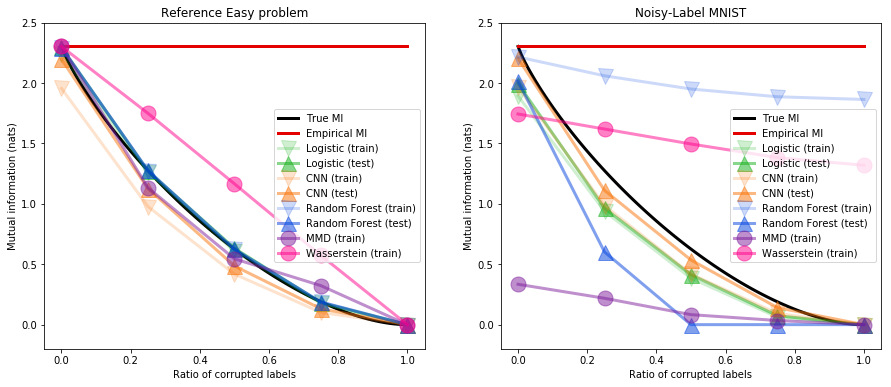

In [29]:
def plot_data(data, label, color, marker=None, **kwargs):
    train_mi = np.log(10) - np.asarray(data['train'])
    test_mi = np.log(10) - np.asarray(data['test'])
    plt.plot(data['corruptions'], np.maximum(train_mi, 0),
             label='{} (train)'.format(label), color=color, 
             alpha=0.2, linewidth=3, markersize=15, marker='v', **kwargs)
    plt.plot(data['corruptions'], np.maximum(test_mi, 0), 
             label='{} (test)'.format(label), color=color, 
             alpha=0.5, linewidth=3, markersize=15, marker='^', **kwargs)
    
def plot_data2(data, label, color, scale=1., marker=None, **kwargs):
    plt.plot(data['corruptions'], scale*np.maximum(data['train'], 0),
             label='{} (train)'.format(label), markersize=15, color=color, 
             marker='o', alpha=0.5, linewidth=3, **kwargs)#, ls='dashed')    

plt.figure(figsize=(15, 6))
MMD_max = np.max(torch.load('reference_mmd.pt')['train'])
MMD_scaling = np.log(10) / MMD_max
Wasserstein_max = np.max(torch.load('reference_wasserstein.pt')['train'])
Wasserstein_scaling = np.log(10) / Wasserstein_max
    
plt.subplot(121)
    

# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('reference_logistic.pt'), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('reference_cnn.pt'), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('reference_rf.pt'), 'Random Forest', 'xkcd:blue', marker=11)
plot_data2(torch.load('reference_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('reference_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    
    
plt.title('Reference Easy problem')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()




plt.subplot(122)


# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='True MI', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data(torch.load('mnist_logistic.pt'), 'Logistic', 'xkcd:green', marker='s')
plot_data(torch.load('mnist_cnn.pt'), 'CNN', 'xkcd:orange', marker=10)
plot_data(torch.load('mnist_rf.pt'), 'Random Forest', 'xkcd:blue', marker=11)
plot_data2(torch.load('mnist_mmd.pt'), 'MMD', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('mnist_wasserstein.pt'), 'Wasserstein', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
    

plt.title('Noisy-Label MNIST')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()

plt.savefig('pmi.pdf')

In [11]:
torch.load('mnist_mmd.pt')

{'corruptions': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'test': [[-0.000567774719092995],
  [0.0010910743021061839],
  [-0.0006525601727238003],
  [0.0003561835902170666],
  [5.7092015049420296e-05]],
 'train': [[0.0008344217358209487],
  [0.0032725801904841018],
  [-0.0006552667027184118],
  [-0.0006251460523344577],
  [-0.001721863803686574]]}

In [13]:
torch.load('reference_mmd.pt')

{'corruptions': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'test': [[0.010616102130270519],
  [0.005225668166203832],
  [0.0025120582583743572],
  [0.001487921724832025],
  [-0.0003301423761611962]],
 'train': [[0.010616102130270519],
  [0.005225668166203832],
  [0.0025120582583743572],
  [0.001487921724832025],
  [-0.0003301423761611962]]}

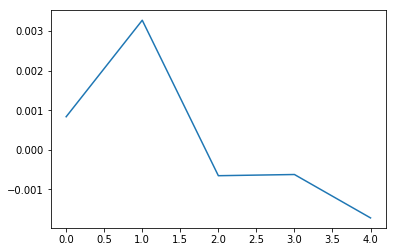

In [14]:
plt.plot(torch.load('mnist_mmd.pt')['train'])